In [1]:
%pip install palmerpenguins


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Dimensiones del dataset: (344, 8)

Primeras filas:
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
3          NaN     NaN  2007  
4       3450.0  female  2007  

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    obje

/var/folders/yg/d2l7cxf50ljf_tnrrzp9czrh0000gn/T/ipykernel_20063/4198303837.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=penguins, x="species", palette="Set2")


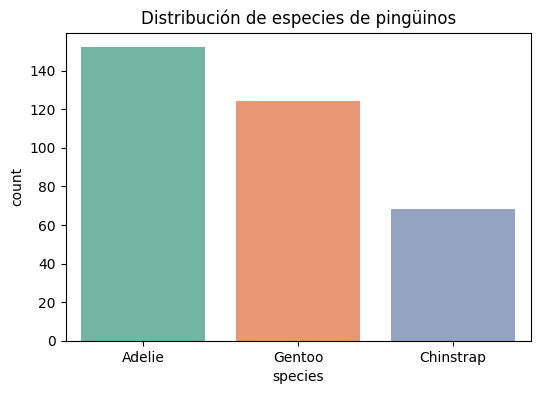

/var/folders/yg/d2l7cxf50ljf_tnrrzp9czrh0000gn/T/ipykernel_20063/4198303837.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=penguins, x="species", y="body_mass_g", palette="Set3")


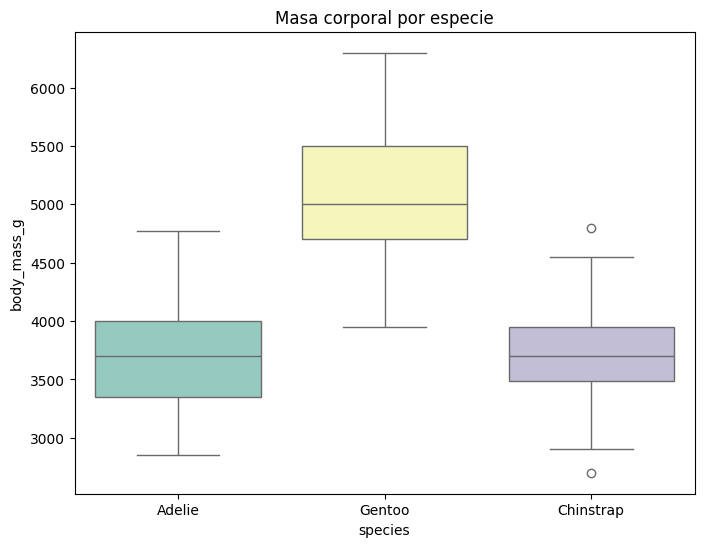

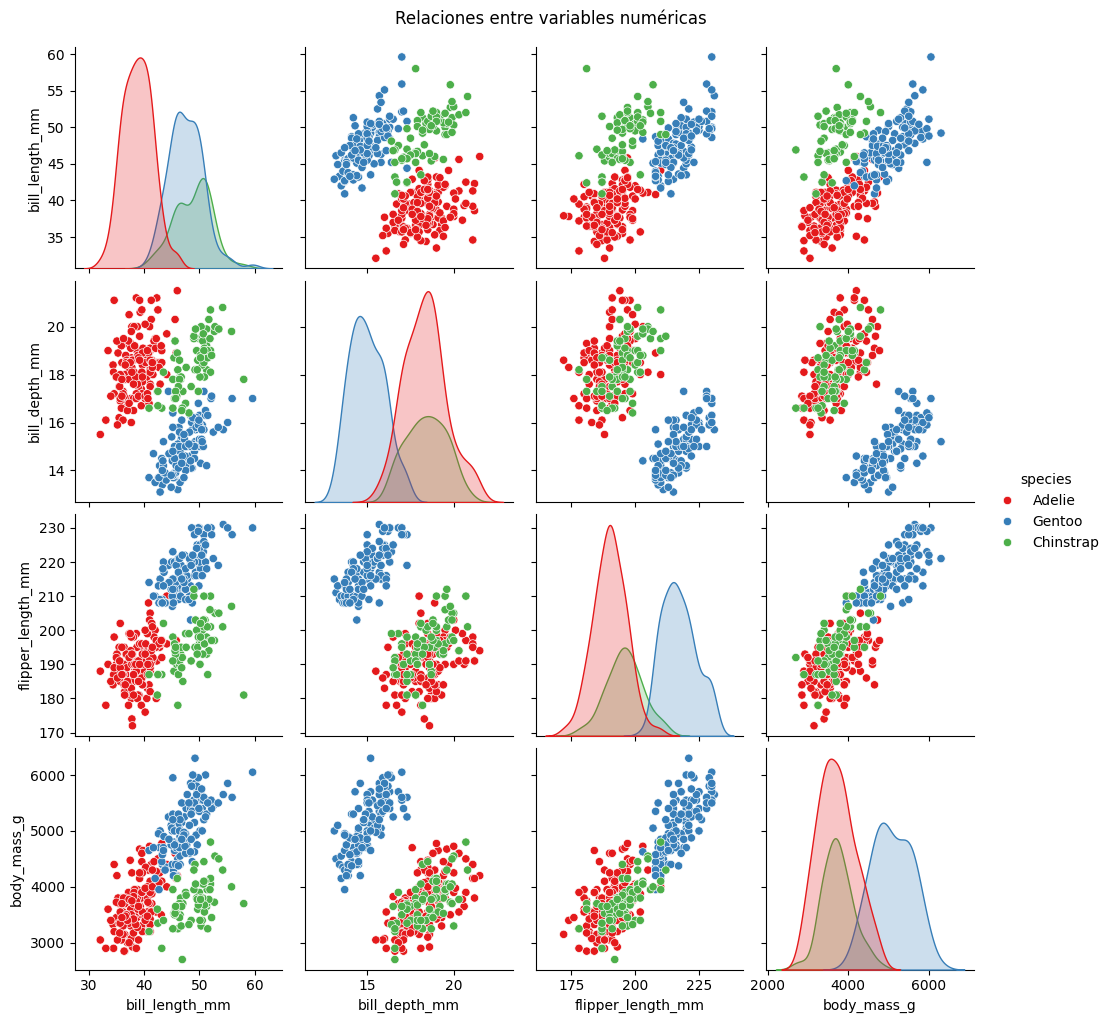

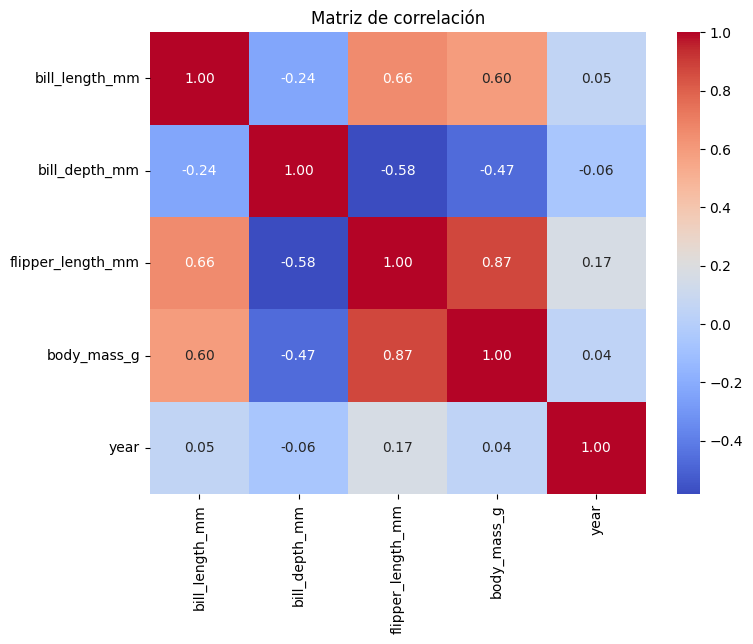

In [2]:
# ============================================
# 1. Importar librerías
# ============================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Librería con el dataset
from palmerpenguins import load_penguins

# ============================================
# 2. Cargar dataset
# ============================================
penguins = load_penguins()

print("Dimensiones del dataset:", penguins.shape)
print("\nPrimeras filas:")
print(penguins.head())

# ============================================
# 3. Información general
# ============================================
print("\nInformación del dataset:")
print(penguins.info())

print("\nValores nulos por columna:")
print(penguins.isnull().sum())

print("\nEstadísticas descriptivas:")
print(penguins.describe(include="all"))

# ============================================
# 4. Distribución de especies
# ============================================
plt.figure(figsize=(6,4))
sns.countplot(data=penguins, x="species", palette="Set2")
plt.title("Distribución de especies de pingüinos")
plt.show()

# ============================================
# 5. Boxplot de variables numéricas por especie
# ============================================
plt.figure(figsize=(8,6))
sns.boxplot(data=penguins, x="species", y="body_mass_g", palette="Set3")
plt.title("Masa corporal por especie")
plt.show()

# ============================================
# 6. Relación entre variables numéricas
# ============================================
sns.pairplot(
    penguins.dropna(), 
    hue="species", 
    vars=["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"],
    palette="Set1"
)
plt.suptitle("Relaciones entre variables numéricas", y=1.02)
plt.show()

# ============================================
# 7. Correlaciones
# ============================================
plt.figure(figsize=(8,6))
corr = penguins.drop(columns=["species", "island", "sex"]).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

In [4]:
# Separar X e y
X = penguins.drop(columns=["species"])
y = penguins["species"]

# ====== 2. Encoder para la variable objetivo ======
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

# ====== 3. Limpieza de texto categórico ======
class CategoryCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        for col in X_copy.columns:
            X_copy[col] = (
                X_copy[col]
                .astype(str)
                .str.strip()
                .str.lower()
                .replace("nan", "desconocido")
            )
        return X_copy

# ====== 4. Columnas ======
numeric_features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
categorical_features = ["island", "sex"]

# ====== 5. Pipelines por tipo ======
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("cleaner", CategoryCleaner()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# ====== 6. Preprocesador completo ======
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# ====== 7. Pipeline final (sin modelo por ahora) ======
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor)
])

# ====== 8. Transformar datos ======
X_ready = pipeline.fit_transform(X)

print("Shape después de preprocesar:", X_ready.shape)
print("Clases objetivo:", target_encoder.classes_)

Shape después de preprocesar: (344, 10)
Clases objetivo: ['Adelie' 'Chinstrap' 'Gentoo']


In [8]:
import time
import numpy as np
import pandas as pd

from palmerpenguins import load_penguins
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# ===== 0) Tus imports y preprocessor previos =====
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Target encoder
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

# Limpieza categórica
class CategoryCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        for col in X_copy.columns:
            X_copy[col] = (
                X_copy[col].astype(str).str.strip().str.lower()
                .replace("nan", "desconocido")
            )
        return X_copy

numeric_features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
categorical_features = ["island", "sex"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Usa salida densa para MLP / HGB:
categorical_transformer = Pipeline(steps=[
    ("cleaner", CategoryCleaner()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    # si tu sklearn >=1.2 puedes usar sparse_output=False
("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# ===== 1) Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ===== 2) Tres modelos rápidos =====
models = {
    "MLP": MLPClassifier(
        hidden_layer_sizes=(32,), activation="relu",
        learning_rate_init=1e-3, alpha=1e-4,
        max_iter=300, early_stopping=True,
        n_iter_no_change=10, random_state=42
    ),
    "HGB": HistGradientBoostingClassifier(
        max_iter=200, learning_rate=0.1, random_state=42
    ),
    "LogReg": LogisticRegression(
        max_iter=600, multi_class="multinomial", n_jobs=-1, random_state=42
    ),
}

results = []
fitted = {}

for name, est in models.items():
    # Clonamos el preprocessor para evitar fugas/leakage de estado entre modelos
    pipe = Pipeline(steps=[
        ("preprocessor", clone(preprocessor)),
        ("model", est)
    ])
    t0 = time.time()
    pipe.fit(X_train, y_train)
    t = time.time() - t0

    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    results.append((name, acc, f1m, t))
    fitted[name] = pipe
    print(f"{name:6s}  acc={acc:.4f}  f1-macro={f1m:.4f}  train_s={t:.2f}")

# ===== 3) Ordenar y mostrar resumen =====
res_df = pd.DataFrame(results, columns=["Modelo", "Accuracy", "F1_macro", "Train_s"])\
         .sort_values(by=["F1_macro", "Accuracy"], ascending=False)
print("\nResumen:\n", res_df.to_string(index=False))

best_name = res_df.iloc[0]["Modelo"]
best_pipe = fitted[best_name]
print(f"\nMejor modelo: {best_name}  -> clases: {list(target_encoder.classes_)}")

# ===== 4) Inferencia de ejemplo (decodificando etiquetas) =====
pred_ids = best_pipe.predict(X.head(5))
pred_labels = target_encoder.inverse_transform(pred_ids)
print("Pred demo:", list(pred_labels))

MLP     acc=0.6522  f1-macro=0.4861  train_s=0.02
HGB     acc=0.9855  f1-macro=0.9829  train_s=0.54


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg  acc=1.0000  f1-macro=1.0000  train_s=1.04

Resumen:
 Modelo  Accuracy  F1_macro  Train_s
LogReg  1.000000  1.000000 1.041104
   HGB  0.985507  0.982856 0.537476
   MLP  0.652174  0.486111 0.020053

Mejor modelo: LogReg  -> clases: ['Adelie', 'Chinstrap', 'Gentoo']
Pred demo: ['Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie']


In [9]:
# =========================================================
# Penguins - Pipelines más “lentos”: MLP, HGB y Logística
# (reusa tu preprocessor con OHE denso y escalado)
# =========================================================
import time
import numpy as np
import pandas as pd
import sklearn

from palmerpenguins import load_penguins
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone

# Modelos
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# ---------------------------
# 1) Datos
# ---------------------------
df = load_penguins().dropna(subset=["species"])
X = df.drop(columns=["species"])
y = df["species"]

# Encoder del target (guárdalo para inferencia)
le = LabelEncoder()
y_enc = le.fit_transform(y)

# ---------------------------
# 2) Preprocesamiento (igual al tuyo)
# ---------------------------
class CategoryCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        for c in X.columns:
            X[c] = (
                X[c].astype("string").str.strip().str.lower()
                .fillna("desconocido").replace("nan", "desconocido")
            )
        return X

num_cols = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
cat_cols = ["island", "sex"]

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Compatibilidad con distintas versiones de sklearn
if sklearn.__version__ >= "1.2":
    onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline(steps=[
    ("clean", CategoryCleaner()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", onehot)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# ---------------------------
# 3) Split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# ---------------------------
# 4) Modelos “más lentos”
# ---------------------------
models = {
    # MLP: más capas y sin early_stopping para forzar todas las iteraciones
    "MLP": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        learning_rate_init=1e-3,
        alpha=1e-4,
        max_iter=800,
        early_stopping=False,
        random_state=42
    ),
    # Árboles por histogramas: más iteraciones y LR más bajo
    "HGB": HistGradientBoostingClassifier(
        max_iter=500,
        learning_rate=0.05,
        random_state=42
    ),
    # Logística: más iteraciones (solver por defecto lbfgs, multinomial)
    "LogReg": LogisticRegression(
        max_iter=2000,
        n_jobs=-1,
        random_state=42
    ),
}

# ---------------------------
# 5) Entrenar, medir y comparar
# ---------------------------
results, fitted = [], {}

for name, est in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", clone(preprocessor)),  # clonar para evitar fugas de estado
        ("model", est)
    ])
    t0 = time.time()
    pipe.fit(X_train, y_train)
    t_train = time.time() - t0

    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")

    results.append((name, acc, f1m, t_train))
    fitted[name] = pipe
    print(f"{name:6s}  acc={acc:.4f}  f1-macro={f1m:.4f}  train_s={t_train:.2f}")

# ---------------------------
# 6) Resumen y mejor modelo
# ---------------------------
res_df = pd.DataFrame(results, columns=["Modelo", "Accuracy", "F1_macro", "Train_s"])\
         .sort_values(by=["F1_macro", "Accuracy"], ascending=False)
print("\nResumen:\n", res_df.to_string(index=False))

best_name = res_df.iloc[0]["Modelo"]
best_pipe = fitted[best_name]
print(f"\nMejor modelo: {best_name}  -> clases: {list(le.classes_)}")

# ---------------------------
# 7) Inferencia de ejemplo (decodificar etiquetas)
# ---------------------------
pred_ids = best_pipe.predict(X.head(5))
pred_labels = le.inverse_transform(pred_ids)
print("Pred demo:", list(pred_labels))

MLP     acc=0.9855  f1-macro=0.9829  train_s=0.07
HGB     acc=0.9855  f1-macro=0.9829  train_s=1.16
LogReg  acc=1.0000  f1-macro=1.0000  train_s=0.73

Resumen:
 Modelo  Accuracy  F1_macro  Train_s
LogReg  1.000000  1.000000 0.733447
   MLP  0.985507  0.982856 0.068905
   HGB  0.985507  0.982856 1.156734

Mejor modelo: LogReg  -> clases: ['Adelie', 'Chinstrap', 'Gentoo']
Pred demo: ['Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie']


In [10]:
# =========================================================
# Penguins - Entrenamiento "lento" (≈5–10 min)
# CV 10x5 + GridSearch en MLP, HGB y LogReg (n_jobs=1)
# Reusa tu preprocesador (imputación + OHE denso + escalado)
# =========================================================
import time
import numpy as np
import pandas as pd
import sklearn

from palmerpenguins import load_penguins
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone

# Modelos
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# ---------------------------
# 1) Datos
# ---------------------------
df = load_penguins().dropna(subset=["species"])
X = df.drop(columns=["species"])
y = df["species"]

# Encoder del target
le = LabelEncoder()
y_enc = le.fit_transform(y)

# ---------------------------
# 2) Preprocesamiento (tu pipeline)
# ---------------------------
class CategoryCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        for c in X.columns:
            X[c] = (
                X[c].astype("string").str.strip().str.lower()
                .fillna("desconocido").replace("nan", "desconocido")
            )
        return X

num_cols = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
cat_cols = ["island", "sex"]

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

if sklearn.__version__ >= "1.2":
    onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline(steps=[
    ("clean", CategoryCleaner()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", onehot)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# ---------------------------
# 3) Split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# ---------------------------
# 4) Configurar CV "lenta"
# ---------------------------
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)  # 50 folds

# ---------------------------
# 5) Definir modelos y grids
# ---------------------------
pipelines = {
    "MLP": Pipeline(steps=[("preprocessor", clone(preprocessor)),
                           ("model", MLPClassifier(random_state=42))]),
    "HGB": Pipeline(steps=[("preprocessor", clone(preprocessor)),
                           ("model", HistGradientBoostingClassifier(random_state=42))]),
    "LogReg": Pipeline(steps=[("preprocessor", clone(preprocessor)),
                              ("model", LogisticRegression(n_jobs=1, random_state=42))]),
}

param_grids = {
    "MLP": {
        "model__hidden_layer_sizes": [(64, 32), (128, 64)],
        "model__activation": ["relu"],
        "model__learning_rate_init": [1e-3, 5e-4],
        "model__alpha": [1e-4, 3e-4],
        "model__max_iter": [600, 1000],
        "model__early_stopping": [False],
    },
    "HGB": {
        "model__max_iter": [400, 700, 1000],
        "model__learning_rate": [0.05, 0.03],
        "model__max_depth": [None, 6],
        "model__l2_regularization": [0.0, 1.0],
    },
    "LogReg": {
        # lbfgs multinomial por defecto; subir iteraciones para que tarde
        "model__C": [0.5, 1.0, 2.0, 5.0],
        "model__max_iter": [2000, 4000],
        "model__penalty": ["l2"],
        # n_jobs=1 para no paralelizar (más lento)
    },
}

# ---------------------------
# 6) GridSearchCV por modelo (n_jobs=1, verbose=1)
# ---------------------------
results = []
best_estimators = {}

for name in ["MLP", "HGB", "LogReg"]:
    print(f"\n===== GridSearch {name} =====")
    gs = GridSearchCV(
        estimator=pipelines[name],
        param_grid=param_grids[name],
        scoring="f1_macro",
        cv=cv,
        n_jobs=1,        # ¡no paralelizar para que tome más tiempo!
        verbose=1,
        refit=True,
        return_train_score=False,
    )
    t0 = time.time()
    gs.fit(X_train, y_train)
    t_train = time.time() - t0

    best_pipe = gs.best_estimator_
    best_estimators[name] = best_pipe

    y_pred = best_pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")

    results.append((name, acc, f1m, t_train, gs.best_params_))
    print(f"-> Mejor {name} en {t_train/60:.2f} min | acc={acc:.4f} | f1-macro={f1m:.4f}")
    print("   Best params:", gs.best_params_)

# ---------------------------
# 7) Resumen y mejor modelo
# ---------------------------
res_df = pd.DataFrame(results, columns=["Modelo", "Accuracy", "F1_macro", "Train_s", "BestParams"])
res_df = res_df.sort_values(by=["F1_macro", "Accuracy"], ascending=False)
print("\nResumen (ordenado por F1_macro):")
print(res_df[["Modelo", "Accuracy", "F1_macro", "Train_s"]].to_string(index=False))

best_name = res_df.iloc[0]["Modelo"]
print(f"\nMejor modelo: {best_name}  -> clases: {list(le.classes_)}")
pred_demo = le.inverse_transform(best_estimators[best_name].predict(X.head(5)))
print("Pred demo:", list(pred_demo))


===== GridSearch MLP =====
Fitting 50 folds for each of 16 candidates, totalling 800 fits
-> Mejor MLP en 1.09 min | acc=0.9855 | f1-macro=0.9829
   Best params: {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__early_stopping': False, 'model__hidden_layer_sizes': (64, 32), 'model__learning_rate_init': 0.001, 'model__max_iter': 600}

===== GridSearch HGB =====
Fitting 50 folds for each of 24 candidates, totalling 1200 fits


KeyboardInterrupt: 

In [11]:
# ================================================
# Penguins - Búsqueda "rápida" (≈ <= 10 minutos)
# MLP (GridSearch), HGB (RandomizedSearch), LogReg (GridSearch)
# Reusa tu preprocesador con OHE denso + escalado
# ================================================
import time, numpy as np, pandas as pd, sklearn, joblib
from palmerpenguins import load_penguins
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone

# Modelos
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# ---------------------------
# 1) Datos
# ---------------------------
df = load_penguins().dropna(subset=["species"])
X = df.drop(columns=["species"])
y = df["species"]

le = LabelEncoder()
y_enc = le.fit_transform(y)

# ---------------------------
# 2) Preprocesador (tu pipeline)
# ---------------------------
class CategoryCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        for c in X.columns:
            X[c] = (
                X[c].astype("string").str.strip().str.lower()
                .fillna("desconocido").replace("nan", "desconocido")
            )
        return X

num_cols = ["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]
cat_cols = ["island","sex"]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

if sklearn.__version__ >= "1.2":
    onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline([
    ("clean", CategoryCleaner()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", onehot)
])

preprocessor = ColumnTransformer(
    [("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
    remainder="drop", verbose_feature_names_out=False
)

# ---------------------------
# 3) Split y CV
# ---------------------------
Xtr, Xte, ytr, yte = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
cv_fast = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)  # 10 folds totales

# ---------------------------
# 4) Búsquedas "rápidas"
# ---------------------------

# 4.1 MLP (grid pequeñito + early_stopping)
mlp_pipe = Pipeline([("preprocessor", clone(preprocessor)),
                     ("model", MLPClassifier(random_state=42))])
mlp_grid = {
    "model__hidden_layer_sizes": [(64,), (64,32)],
    "model__activation": ["relu"],
    "model__learning_rate_init": [1e-3, 5e-4],
    "model__alpha": [1e-4, 3e-4],
    "model__early_stopping": [True],
    "model__max_iter": [600],
}
mlp_gs = GridSearchCV(mlp_pipe, mlp_grid, scoring="f1_macro",
                      cv=cv_fast, n_jobs=-1, verbose=1, refit=True)

# 4.2 HGB (random search + early_stopping para cortar antes)
hgb_pipe = Pipeline([("preprocessor", clone(preprocessor)),
                     ("model", HistGradientBoostingClassifier(random_state=42, early_stopping=True,
                                                              validation_fraction=0.1, n_iter_no_change=20))])
hgb_dist = {
    "model__max_iter": [300, 500, 700, 900],
    "model__learning_rate": [0.03, 0.05, 0.08],
    "model__max_depth": [None, 6, 8],
    "model__l2_regularization": [0.0, 0.5, 1.0],
    # opcional: "model__min_samples_leaf": [10, 20, 30],
}
hgb_rs = RandomizedSearchCV(hgb_pipe, hgb_dist, n_iter=12,  # <= 12 candidatos
                            scoring="f1_macro", cv=cv_fast, n_jobs=-1,
                            verbose=1, random_state=42, refit=True)

# 4.3 LogReg (grid pequeño)
log_pipe = Pipeline([("preprocessor", clone(preprocessor)),
                     ("model", LogisticRegression(n_jobs=-1, random_state=42, solver="lbfgs"))])
log_grid = {
    "model__C": [0.5, 1.0, 2.0, 5.0],
    "model__max_iter": [1500, 3000],
    "model__penalty": ["l2"],
}
log_gs = GridSearchCV(log_pipe, log_grid, scoring="f1_macro",
                      cv=cv_fast, n_jobs=-1, verbose=1, refit=True)

# ---------------------------
# 5) Ejecutar (medir tiempo)
# ---------------------------
def run_search(name, search):
    t0 = time.time(); search.fit(Xtr, ytr); secs = time.time() - t0
    ypred = search.best_estimator_.predict(Xte)
    acc = accuracy_score(yte, ypred); f1m = f1_score(yte, ypred, average="macro")
    print(f"\n>>> {name}: {secs/60:.2f} min | acc={acc:.4f} | f1={f1m:.4f}")
    print("Best params:", search.best_params_)
    return {"name": name, "secs": secs, "acc": acc, "f1": f1m, "est": search.best_estimator_}

results = []
results.append(run_search("MLP", mlp_gs))
results.append(run_search("HGB", hgb_rs))
results.append(run_search("LogReg", log_gs))

# ---------------------------
# 6) Resumen y guardado
# ---------------------------
res_df = pd.DataFrame([{"Modelo": r["name"], "Tiempo_s": r["secs"], "Accuracy": r["acc"], "F1_macro": r["f1"]} for r in results])\
         .sort_values(by=["F1_macro","Accuracy"], ascending=False)
print("\nResumen:\n", res_df.to_string(index=False))

# Guardar los 3 mejores (uno por nombre)
for r in results:
    joblib.dump(r["est"], f"penguins_pipeline_{r['name']}.joblib")
joblib.dump(le, "penguins_target_encoder.joblib")
print("\nGuardados:")
for r in results:
    print(f" - penguins_pipeline_{r['name']}.joblib")
print(" - penguins_target_encoder.joblib")

# Demo inferencia con el mejor
best = results[0]["est"]
pred_demo = le.inverse_transform(best.predict(X.head(5)))
print("\nPred demo:", list(pred_demo))

Fitting 10 folds for each of 8 candidates, totalling 80 fits

>>> MLP: 0.03 min | acc=0.8696 | f1=0.8234
Best params: {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__early_stopping': True, 'model__hidden_layer_sizes': (64, 32), 'model__learning_rate_init': 0.001, 'model__max_iter': 600}
Fitting 10 folds for each of 12 candidates, totalling 120 fits

>>> HGB: 0.07 min | acc=0.9565 | f1=0.9629
Best params: {'model__max_iter': 700, 'model__max_depth': 8, 'model__learning_rate': 0.03, 'model__l2_regularization': 0.0}
Fitting 10 folds for each of 8 candidates, totalling 80 fits

>>> LogReg: 0.00 min | acc=0.9855 | f1=0.9829
Best params: {'model__C': 5.0, 'model__max_iter': 1500, 'model__penalty': 'l2'}

Resumen:
 Modelo  Tiempo_s  Accuracy  F1_macro
LogReg  0.258528  0.985507  0.982856
   HGB  4.389002  0.956522  0.962850
   MLP  1.852075  0.869565  0.823411

Guardados:
 - penguins_pipeline_MLP.joblib
 - penguins_pipeline_HGB.joblib
 - penguins_pipeline_LogReg.joblib
 - pengui

In [ ]:

import time, numpy as np, pandas as pd, sklearn, joblib
from palmerpenguins import load_penguins
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


CV_SPLITS   = 10
CV_REPEATS  = 5     # 50 folds totales
HGB_N_ITER  = 12    # 12 candidatos -> ~600 fits
N_JOBS_CV   = 1     # MUY IMPORTANTE: sin paralelismo para alargar el tiempo

# ---------------------------
# 1) Datos
# ---------------------------
df = load_penguins().dropna(subset=["species"])
X = df.drop(columns=["species"])
y = df["species"]

le = LabelEncoder()
y_enc = le.fit_transform(y)

# ---------------------------
# 2) Preprocesador (igual al tuyo)
# ---------------------------
class CategoryCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        for c in X.columns:
            X[c] = (
                X[c].astype("string").str.strip().str.lower()
                .fillna("desconocido").replace("nan", "desconocido")
            )
        return X

num_cols = ["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]
cat_cols = ["island","sex"]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

if sklearn.__version__ >= "1.2":
    onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline([
    ("clean", CategoryCleaner()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", onehot)
])

preprocessor = ColumnTransformer(
    [("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
    remainder="drop", verbose_feature_names_out=False
)

# ---------------------------
# 3) Split y CV
# ---------------------------
Xtr, Xte, ytr, yte = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
cv = RepeatedStratifiedKFold(n_splits=CV_SPLITS, n_repeats=CV_REPEATS, random_state=42)



mlp_pipe = Pipeline([("preprocessor", clone(preprocessor)),
                     ("model", MLPClassifier(random_state=42))])
mlp_grid = {
    "model__hidden_layer_sizes": [(64,), (64,32), (128,), (128,64)],
    "model__activation": ["relu"],
    "model__learning_rate_init": [1e-3, 5e-4],
    "model__alpha": [1e-4, 3e-4],
    "model__max_iter": [1000],
    "model__early_stopping": [False],
}
mlp_gs = GridSearchCV(mlp_pipe, mlp_grid, scoring="f1_macro",
                      cv=cv, n_jobs=N_JOBS_CV, verbose=1, refit=True)

# HGB: RandomizedSearch con 12 candidatos x 50 folds ≈ 600 fits (la parte más pesada)
hgb_pipe = Pipeline([("preprocessor", clone(preprocessor)),
                     ("model", HistGradientBoostingClassifier(
                         random_state=42, early_stopping=False))])  # sin early_stopping para gastar tiempo
hgb_dist = {
    "model__max_iter": [500, 700, 900, 1100],
    "model__learning_rate": [0.03, 0.05, 0.08],
    "model__max_depth": [None, 6, 8, 10],
    "model__l2_regularization": [0.0, 0.5, 1.0],
    "model__min_samples_leaf": [10, 20, 30],
}
hgb_rs = RandomizedSearchCV(hgb_pipe, hgb_dist, n_iter=HGB_N_ITER,
                            scoring="f1_macro", cv=cv, n_jobs=N_JOBS_CV,
                            verbose=1, random_state=42, refit=True)

# LogReg: 8 candidatos x 50 folds = 400 fits
log_pipe = Pipeline([("preprocessor", clone(preprocessor)),
                     ("model", LogisticRegression(random_state=42, solver="lbfgs", multi_class="auto"))])
log_grid = {
    "model__C": [0.5, 1.0, 2.0, 5.0],
    "model__max_iter": [3000, 5000],
    "model__penalty": ["l2"],
}
log_gs = GridSearchCV(log_pipe, log_grid, scoring="f1_macro",
                      cv=cv, n_jobs=N_JOBS_CV, verbose=1, refit=True)

# ---------------------------
# 5) Ejecutar y medir
# ---------------------------
def run_search(name, search):
    t0 = time.time(); search.fit(Xtr, ytr); secs = time.time() - t0
    ypred = search.best_estimator_.predict(Xte)
    acc = accuracy_score(yte, ypred); f1m = f1_score(yte, ypred, average="macro")
    print(f"\n>>> {name}: {secs/60:.2f} min | acc={acc:.4f} | f1={f1m:.4f}")
    print("Best params:", search.best_params_)
    return {"name": name, "secs": secs, "acc": acc, "f1": f1m, "est": search.best_estimator_}

results = []
results.append(run_search("MLP", mlp_gs))
results.append(run_search("HGB", hgb_rs))
results.append(run_search("LogReg", log_gs))

# ---------------------------
# 6) Resumen + guardado de los 3
# ---------------------------
res_df = pd.DataFrame([{"Modelo": r["name"], "Tiempo_s": r["secs"], "Accuracy": r["acc"], "F1_macro": r["f1"]} for r in results])\
         .sort_values(by=["F1_macro","Accuracy"], ascending=False)
print("\nResumen:\n", res_df.to_string(index=False))

for r in results:
    joblib.dump(r["est"], f"penguins_pipeline_{r['name']}.joblib")
joblib.dump(le, "penguins_target_encoder.joblib")
print("\nGuardados:")
for r in results:
    print(f" - penguins_pipeline_{r['name']}.joblib")
print(" - penguins_target_encoder.joblib")

# Demo
best = results[0]["est"]
pred_demo = le.inverse_transform(best.predict(X.head(5)))
print("\nPred demo:", list(pred_demo))

Fitting 50 folds for each of 16 candidates, totalling 800 fits

>>> MLP: 1.14 min | acc=0.9855 | f1=0.9829
Best params: {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__early_stopping': False, 'model__hidden_layer_sizes': (64, 32), 'model__learning_rate_init': 0.001, 'model__max_iter': 1000}
Fitting 50 folds for each of 12 candidates, totalling 600 fits

>>> HGB: 18.21 min | acc=0.9855 | f1=0.9829
Best params: {'model__min_samples_leaf': 20, 'model__max_iter': 1100, 'model__max_depth': 6, 'model__learning_rate': 0.05, 'model__l2_regularization': 0.0}
Fitting 50 folds for each of 8 candidates, totalling 400 fits


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio


>>> LogReg: 0.06 min | acc=0.9855 | f1=0.9829
Best params: {'model__C': 5.0, 'model__max_iter': 3000, 'model__penalty': 'l2'}

Resumen:
 Modelo    Tiempo_s  Accuracy  F1_macro
   MLP   68.303003  0.985507  0.982856
   HGB 1092.738956  0.985507  0.982856
LogReg    3.475419  0.985507  0.982856

Guardados:
 - penguins_pipeline_MLP.joblib
 - penguins_pipeline_HGB.joblib
 - penguins_pipeline_LogReg.joblib
 - penguins_target_encoder.joblib

Pred demo: ['Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie']


In [17]:
import sklearn, pandas, numpy, joblib#, #fastapi, uvicorn

print("scikit-learn:", sklearn.__version__)
print("pandas:", pandas.__version__)
print("numpy:", numpy.__version__)
print("joblib:", joblib.__version__)
#print("fastapi:", fastapi.__version__)
#import uvicorn
#print("uvicorn:", uvicorn.__version__)

scikit-learn: 1.6.1
pandas: 2.2.3
numpy: 2.0.2
joblib: 1.5.0
